In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

/tmp/ipykernel_9238/1056814220.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_9238/1056814220.py:25: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana_f", cmap)


## data female

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_female = pd.concat([sample,sample2])
df_female = sample.copy()
df_female.rename(columns={'binned_age': 'age'}, inplace=True)
df_female.set_index(['age', 'mouse'], inplace=True)

## data males

In [6]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male = sample.copy()
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

## normalized

In [7]:
# avarage per age or session
f_df= df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [8]:
## joint data
m_data=m_df.copy()
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data=f_df.copy()
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

In [9]:
format_plots()

In [10]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in f_data.groupby('age'):
    inter_ind_dists = pdist(_df, metric='jensenshannon')
    iid[age] = inter_ind_dists
    #iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age, mouse=_df.index.get_level_values('mouse'))))
iid_df = pd.concat(iid_df)
iid_avg_df_f = pd.concat(iid_avg_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


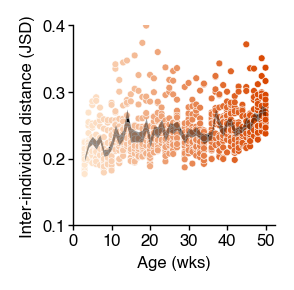

In [11]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=6,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.1, 0.4),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0,10,20,30,40,50],
)
sns.despine()

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_female_JSD.pdf')

In [13]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in m_data.groupby('age'):
    inter_ind_dists = pdist(_df, metric='jensenshannon')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age, mouse=_df.index.get_level_values('mouse'))))
iid_df = pd.concat(iid_df)
iid_avg_df_m = pd.concat(iid_avg_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


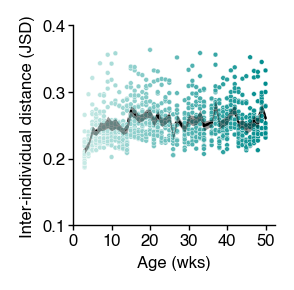

In [14]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))

a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.1, 0.4),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0,10,20,30,40,50],
)
sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_male_JSD.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

<Axes: xlabel='age', ylabel='iid'>

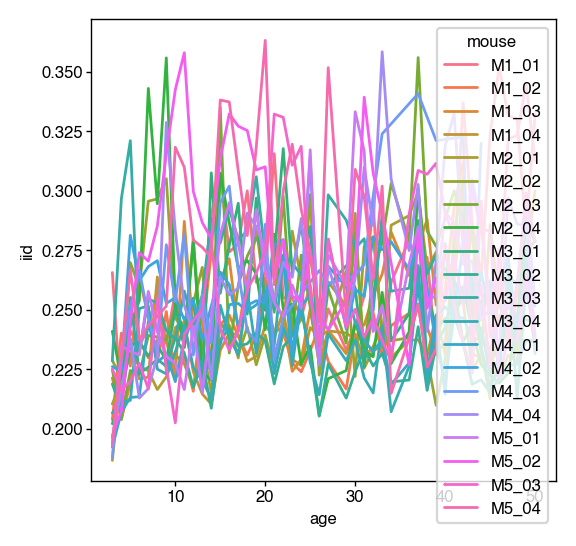

In [17]:
sns.lineplot(data=iid_avg_df_m, x='age', y='iid',hue='mouse')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

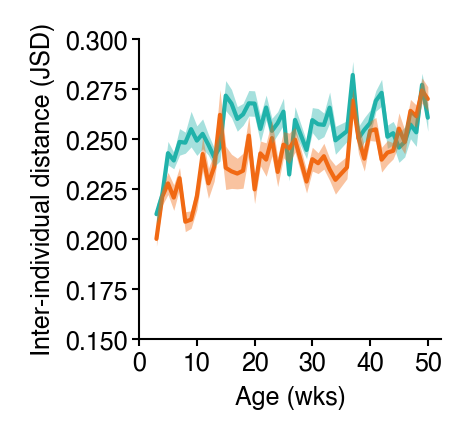

In [16]:
fig = figure(1.3, 1.3)
ax = fig.gca()
'''
a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
'''
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='#20B2AA',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)


a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='#f16913',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.15, 0.3),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0,10,20,30,40,50],
)

sns.despine()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_fvm_JSD.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

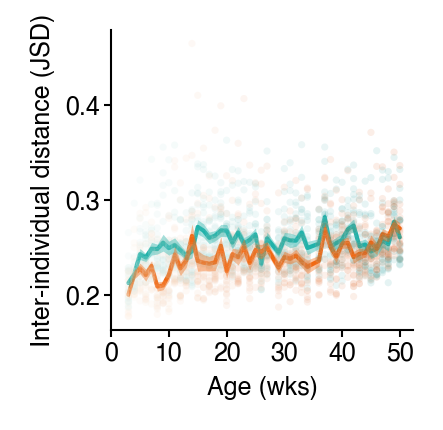

In [18]:
fig = figure(1.3, 1.3)
ax = fig.gca()

a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=0.1,
    zorder=1,
)
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=0.1,
    zorder=1,
)

a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='#20B2AA',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)


a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='#f16913',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    #ylim=(0.2, 0.3),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0,10,20,30,40,50],
)

sns.despine()

In [19]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_fvm_JSD_ylim.pdf')

In [20]:
def fit_2mixed_linear_models(data, dependent_var, factor1,factor2, group):
    
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]

    #formula = f'ranked_response ~ {factor1}*{group}'
    formula = f'ranked_response ~ {factor1}*C({factor2})'
        
    # Fit the mixed linear model
    model = smf.mixedlm(formula, align_data, groups=f'{group}')
    result = model.fit()
    return result

def extract_summary_to_dataframe(results, num_tests):
    summary_data = []

    for var, result in results.items():
        summary = result.summary()
        coefs = result.params
        pvalues = result.pvalues
        conf_int = result.conf_int()
        
        for param in coefs.index:
            pvalue_corrected = min(pvalues[param] * num_tests, 1.0)  # Apply Bonferroni correction
            
            summary_data.append({
                'Dependent Variable': var,
                'Parameter': param,
                'Coefficient': coefs[param],
                'P-value': pvalues[param],
                'Corrected P-value': pvalue_corrected,
                'CI Lower': conf_int[0][param],
                'CI Upper': conf_int[1][param]
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [21]:
iid_avg_df_m['sex']='m'
iid_avg_df_f['sex']='f'
temp=pd.concat([iid_avg_df_m,iid_avg_df_f])

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate
result=fit_2mixed_linear_models(temp, 'iid', 'age','sex','mouse')
num_tests = 1  # Number of tests is the number of dependent variables (excluding 'age' and 'mouse')
#summary_df = extract_summary_to_dataframe(result, num_tests)

# Print the DataFrame nicely
print(summary_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


AttributeError: 'MixedLMResults' object has no attribute 'items'

In [30]:
import pandas as pd
from statsmodels.regression.mixed_linear_model import MixedLMResults

# Initialize variables
results = []
dependent_variable = 'Inter-indv distance (JSD)'
n_tests = 1  # Adjust this value if you have more tests to account for multiple comparisons

# Assuming `result` is an instance of MixedLMResults
# Add dependent variable to the results
result_dict = result.summary().tables[1]  # Assuming result is your MixedLMResults object
result_dict['Dependent Variable'] = dependent_variable
results.append(result_dict)

# Combine results into a DataFrame
results_df = pd.concat(results).reset_index()
results_df.rename(columns={'index': 'Parameter'}, inplace=True)

# Move the 'Dependent Variable' column to the first position
cols = ['Dependent Variable'] + [col for col in results_df.columns if col != 'Dependent Variable']
results_df = results_df[cols]

# Apply Bonferroni correction to the p-values
if 'P>|z|' in results_df.columns:  # Ensure the p-value column is correctly identified
    results_df['Bonferroni_corrected_p'] = results_df['P>|z|'] * n_tests
    #results_df['Bonferroni_corrected_p'] = results_df['Bonferroni_corrected_p'].apply(lambda p: min(p, 1))  # p-values should not exceed 1

# Save DataFrame to CSV file
results_df.to_csv('mixedlm_JSD_longtogeny.csv', index=False)

print("MixedLM results with Bonferroni-corrected p-values have been saved to 'mixedlm_JSD_longtogeny.csv'")

MixedLM results with Bonferroni-corrected p-values have been saved to 'mixedlm_JSD_longtogeny.csv'


In [ ]:
# sm0oth version

/tmp/ipykernel_9238/2766505413.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  a = sns.lineplot(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


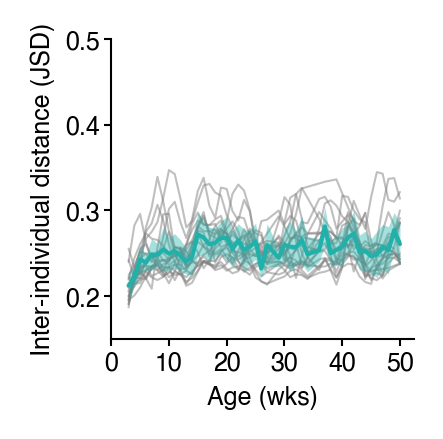

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
fig = figure(1.3, 1.3)
ax = fig.gca()

# Sample data preparation
# Assuming 'iid_avg_df_m' and 'iid_avg_df_f' are your DataFrames for male and female mice
# Each DataFrame has columns: 'age', 'iid', 'mouse'

# Define a function to smooth the data
def smooth_data(y, window_size=5, poly_order=2):
    return savgol_filter(y, window_size, poly_order)

# Plot individual lines for male mice
for mouse in iid_avg_df_m['mouse'].unique():
    mouse_data = iid_avg_df_m[iid_avg_df_m['mouse'] == mouse]
    smooth_iid = smooth_data(mouse_data['iid'])
    plt.plot(mouse_data['age'], smooth_iid, color='grey', lw=0.5, alpha=0.5, zorder=-2)

# Plot mean line for male mice with error bars
iid_avg_df_m['smoothed_iid'] = iid_avg_df_m.groupby('age')['iid'].transform(smooth_data)
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="smoothed_iid",
    color='#20B2AA',
    ci='sd',
    err_kws={"lw": 0, "alpha": 0.4},
)

# Set plot parameters
a.set(
    ylim=(0.15, 0.5),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0, 10, 20, 30, 40, 50],
)

sns.despine()
plt.show()

/tmp/ipykernel_9238/159629498.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  a = sns.lineplot(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


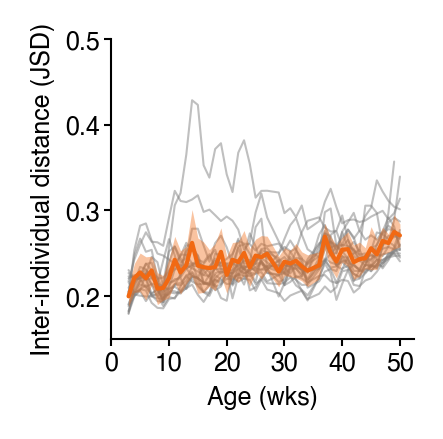

In [50]:
fig = figure(1.3, 1.3)
ax = fig.gca()

# Plot individual lines for female mice
for mouse in iid_avg_df_f['mouse'].unique():
    mouse_data = iid_avg_df_f[iid_avg_df_f['mouse'] == mouse]
    smooth_iid = smooth_data(mouse_data['iid'])
    plt.plot(mouse_data['age'], smooth_iid, color='grey', lw=0.5, alpha=0.5, zorder=-2)

# Plot mean line for female mice with error bars
iid_avg_df_f['smoothed_iid'] = iid_avg_df_f.groupby('age')['iid'].transform(smooth_data)
a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="smoothed_iid",
    color='#f16913',
    ci='sd',
    err_kws={"lw": 0, "alpha": 0.4},
)

# Set plot parameters
a.set(
    ylim=(0.15, 0.5),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    xticks=[0, 10, 20, 30, 40, 50],
)
sns.despine()
plt.show()

TypeError: __main__.plot_mean() got multiple values for keyword argument 'color'

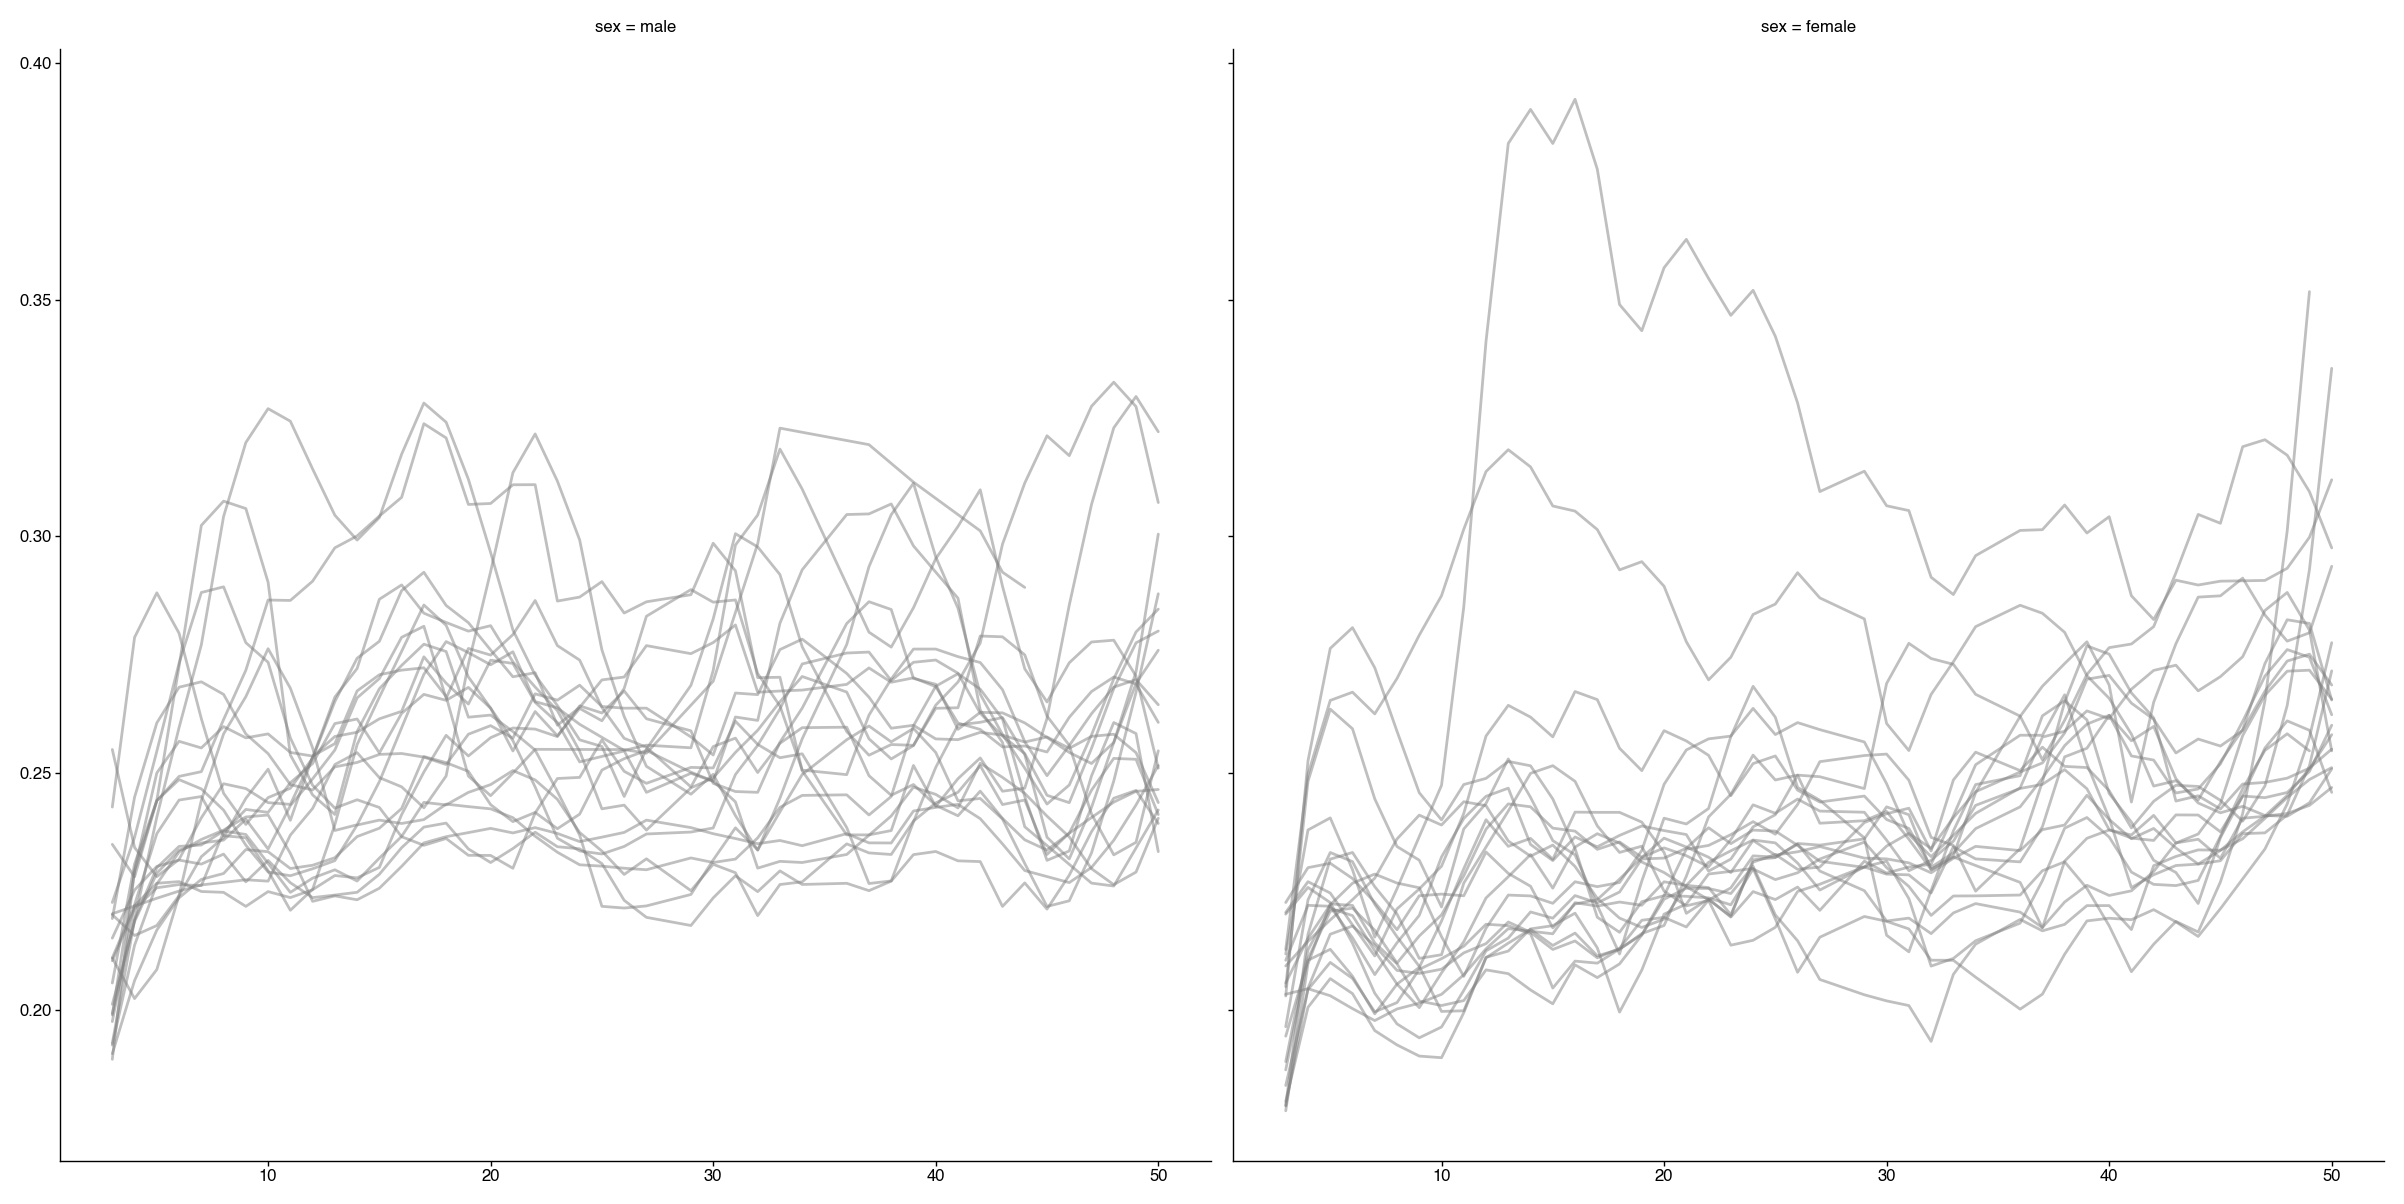

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Sample data preparation
# Assuming 'iid_avg_df_m' and 'iid_avg_df_f' are your DataFrames for male and female mice
# Each DataFrame has columns: 'age', 'iid', 'mouse'

# Combine male and female data into one DataFrame and add a 'sex' column
iid_avg_df_m['sex'] = 'male'
iid_avg_df_f['sex'] = 'female'
data = pd.concat([iid_avg_df_m, iid_avg_df_f])

# Define a function to smooth the data
def smooth_data(y, window_size=9, poly_order=3):
    return savgol_filter(y, window_size, poly_order)

# Apply smoothing to the data
data['smoothed_iid'] = data.groupby(['sex', 'mouse'])['iid'].transform(lambda x: smooth_data(x))

# Set up the FacetGrid for side-by-side plots
g = sns.FacetGrid(data, col="sex", sharey=True, height=6, aspect=1)

# Plot individual lines for each mouse in grey
def plot_individuals(data, **kwargs):
    for mouse in data['mouse'].unique():
        mouse_data = data[data['mouse'] == mouse]
        plt.plot(mouse_data['age'], mouse_data['smoothed_iid'], color='grey', alpha=0.5, zorder=-2)

# Plot mean line with standard error
def plot_mean(data, color, **kwargs):
    sns.lineplot(
        data=data,
        x='age',
        y='smoothed_iid',
        color=color,
        ci='sd',
        **kwargs
    )

# Apply the plotting functions to the FacetGrid
g.map_dataframe(plot_individuals)
g.map_dataframe(lambda data, **kwargs: plot_mean(data[data['sex'] == 'male'], color='#20B2AA', **kwargs))
g.map_dataframe(lambda data, **kwargs: plot_mean(data[data['sex'] == 'female'], color='#f16913', **kwargs))

# Set plot parameters
g.set_axis_labels("Age (wks)", "Inter-individual distance (JSD)")
g.set(ylim=(0.15, 0.3), xlim=(0, None))
g.set_xticklabels([0, 10, 20, 30, 40, 50])

# Despine and show plot
sns.despine()
plt.show()
